In [1]:
import json
import ROOT
from analysis_framework import Dataset, WWAnalysis
import os

OBJ: TStyle	ildStyle	ILD Style : 0 at: 0x638ade0


In [2]:
# urgh the OOs cannot handle this!!!!
# ROOT.EnableImplicitMT(12)

In [3]:
# CLD
# x_angle = 0.030 # rad
# ILD
x_angle = 0.014 # rad
# use same masses as in whizard!
mW = 80.419
mZ = 91.1882

In [4]:

ROOT.gSystem.Load("OO/diehl/libObservable.so")
ROOT.gInterpreter.Declare("#include \"OO/diehl/OOTools.h\"")
ROOT.OOTools.init(250, mW, mZ)

In [5]:
# dataset = Dataset.from_json("data/datasets/snapshots/full.json")
# dataset = Dataset.from_json("checked-test.json")
# dataset = Dataset.from_json("checked-full.json")
dataset = Dataset.from_json("checked-signal-only-full-local.json")

In [6]:
analysis = WWAnalysis(dataset)
# analysis.init_parameters([
#     ("Energy", "float", "-1.0"),
# ])
ROOT.gInterpreter.Declare("#include <podio/GenericParameters.h>")
analysis.Define("params_Energy", "Parameters.get<float>(\"Energy\").value_or(-1.0)")

In [7]:
analysis.set_categories({
    "4f_sw_sl_eLpL": {"pattern": "4f_sw_sl_eLpL", "cut": None},
    "4f_sw_sl_eRpL": {"pattern": "4f_sw_sl_eRpL", "cut": None},
    "4f_sw_sl_eRpR": {"pattern": "4f_sw_sl_eRpR", "cut": None},
    "4f_sw_sl_eLpR": {"pattern": "4f_sw_sl_eLpR", "cut": None},
})
# check if we missed any processes
print(analysis.is_complete_categorisation())

True


In [8]:
print(json.dumps(analysis._categories, indent=2))

{
  "4f_sw_sl_eLpL": [
    "4f_sw_sl_eLpL_signal"
  ],
  "4f_sw_sl_eRpL": [
    "4f_sw_sl_eRpL_signal"
  ],
  "4f_sw_sl_eRpR": [
    "4f_sw_sl_eRpR_signal"
  ],
  "4f_sw_sl_eLpR": [
    "4f_sw_sl_eLpR_signal"
  ]
}


In [9]:
# needed for the .size() calls... alternative would probably be to .Alias the @size columns
ROOT.gInterpreter.Declare("#include <podio/ObjectID.h>")
ROOT.gInterpreter.Declare("#include <edm4hep/ReconstructedParticleData.h>")
make_lvec = lambda coll_name: f"ROOT::VecOps::Construct<ROOT::Math::PxPyPzEVector>({coll_name}.momentum.x, {coll_name}.momentum.y, {coll_name}.momentum.z, {coll_name}.energy)"
analysis.Define("R2jet_lvecs", make_lvec("Refined2Jets"))
analysis.Define("n_neutral_PFOs", "Sum(abs(PandoraPFOs.charge) == 0.)")
analysis.Define("charged_fraction", "n_charged_PFOs / static_cast<double>(n_charged_PFOs + n_neutral_PFOs)")

In [10]:
# filter on missing energy > 0

In [ ]:
# TODO: define truth objects! (Not super trivial for the quarks without truejet but should be doable)
# well I can just take the quarks before hadronisation...
# take first genstat 1 e and nu and first two gen stat 2 pdg below 6
first_stable = lambda pdg: f"""
auto lepton_mask = genStat == 1 && abs(pdg) == {pdg};
// abuse ArgMax to get the first set position
auto lepton_idx = ArgMax(lepton_mask);
return lepton_idx;
"""
# TODO: finish implementation
first_two_unstable_below = lambda pdg: f"""
auto lepton_mask = genStat == 2 && abs(pdg) < {pdg};
// abuse ArgMax to get the first set position
auto lepton_idx = ArgMax(lepton_mask);
return lepton_idx;
"""

In [ ]:
analysis.define_reco_objects(x_angle)
analysis.remove_x_angle(x_angle)
analysis.define_hagiwara_angles()
analysis.define_OO()

In [16]:
analysis.Define("nu_E", "ub_nu_lvec.energy()")
analysis.Define("M_Wlep", "ub_leptonic_W_lvec.M()")
analysis.Define("M_Whad", "ub_hadronic_W_lvec.M()")

In [17]:
# analysis.add_filter("iso_lep_charge < 0.", "only Wm")
analysis.add_filter("M_Wlep > 0.", "Wlep real")
# analysis.add_filter(f"abs(M_Wlep - {mW}) < 15", "W_lep 15 GeV")
# analysis.add_filter(f"abs(M_Whad - {mW}) < 20", "W_had 20 GeV")

In [18]:

analysis.book_histogram_1D("RecoCatAdvanced", "RecoCatAdvanced", ("", ";RecoCatAdvanced", 8, 0., 8.))
analysis.book_histogram_1D("n_isoelectrons", "n_isoelectrons", ("", ";n_isoelectrons", 5, 0., 5.))
analysis.book_histogram_1D("n_charged_PFOs", "n_charged_PFOs", ("", ";n_charged_PFOs", 50, 0., 50.))
analysis.book_histogram_1D("n_neutral_PFOs", "n_neutral_PFOs", ("", ";n_neutral_PFOs", 50, 0., 50.))
analysis.book_histogram_1D("misspT", "params_WWCategorisation_misspT", ("", ";misspT", 100, 0., 100.))
analysis.book_histogram_1D("PVertex_ndf", "PVertex_ndf", ("", ";PVertex_ndf", 50, 1., 101.))
analysis.book_histogram_1D("missE", "params_WWCategorisation_missE", ("", ";missE", 300, -50., 250.))
analysis.book_histogram_1D("mInv", "params_WWCategorisation_mInv", ("", ";mInv", 100, 40., 140.))
analysis.book_histogram_1D("M_jj", "M_jj", ("", ";M_jj", 100, 32., 132.))
analysis.book_histogram_1D("n_isomuons", "n_isomuons", ("", ";n_isomuons", 5, 0., 5.))
analysis.book_histogram_1D("PVertex_chi2", "PVertex_chi2", ("", ";PVertex_chi2", 75, 0., 150.))
analysis.book_histogram_1D("PVertex_chi2ndf", "PVertex_chi2ndf", ("", ";PVertex_chi2/ndf", 20, 0., 10.))
analysis.book_histogram_1D("charged_fraction", "charged_fraction", ("", ";charged_fraction", 50, 0., 1.))
analysis.book_histogram_1D("O_1", "O_1", ("", ";O_1", 100, -1., 1.))
analysis.book_histogram_1D("O_2", "O_2", ("", ";O_1", 100, -1., 1.))
analysis.book_histogram_1D("O_3", "O_3", ("", ";O_1", 100, -1., 1.))
analysis.book_histogram_1D("S_0", "S_0", ("", ";S_0", 50, -0., 250.))
analysis.book_histogram_1D("S_1_1", "S_1_1", ("", ";S_1_1", 50, -10., 10.))
analysis.book_histogram_1D("co", "co", ("", ";co", 50, -1., 1.))
analysis.book_histogram_1D("co1", "co1", ("", ";co1", 50, -1., 1.))
analysis.book_histogram_1D("ph1", "ph1", ("", ";co1", 50, -3.14159, 3.14159))
analysis.book_histogram_1D("nu_E", "nu_E", ("", ";nu_E", 300, -50., 250.))
analysis.book_histogram_1D("M_Wlep", "M_Wlep", ("", ";M_Wlep", 300, -100., 200.))
analysis.book_histogram_1D("M_Whad", "M_Whad", ("", ";M_Whad", 160, 40., 200.))

In [19]:
analysis.book_reports()

In [20]:
%%time
analysis.run()

CPU times: user 56.9 s, sys: 3.6 s, total: 1min
Wall time: 1min 13s
OBJ: TStyle	ildStyle	ILD Style : 0 at: 0x10d4d1d0


In [21]:
analysis.print_reports()

       4f_sw_sl_eLpL       4f_sw_sl_eRpL       4f_sw_sl_eRpR       4f_sw_sl_eLpR
        118909 (5e+02)         87929 (2e+02)        117376 (5e+02)      10125353 (1e+04) All
        115879 (5e+02)         83986 (2e+02)        114223 (5e+02)       9686033 (1e+04) Wlep real
          0.97          0.96          0.97          0.96 efficiency


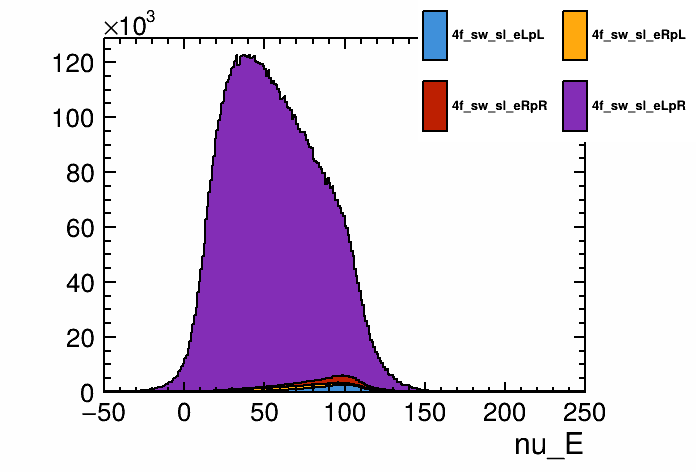

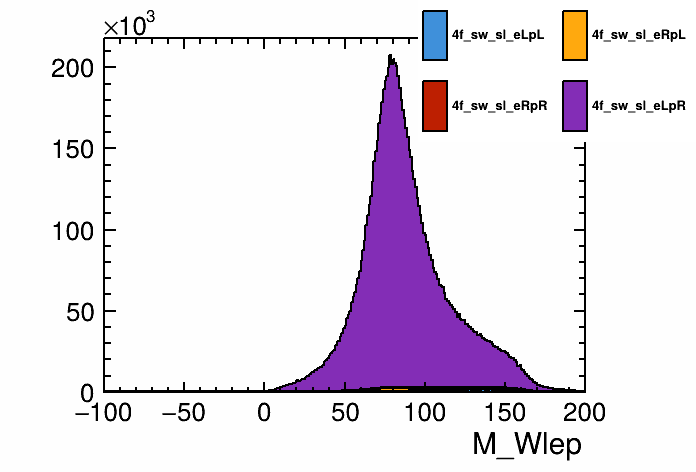

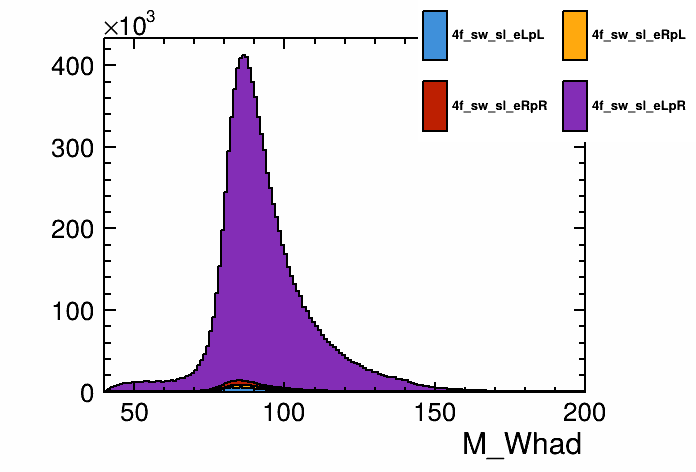

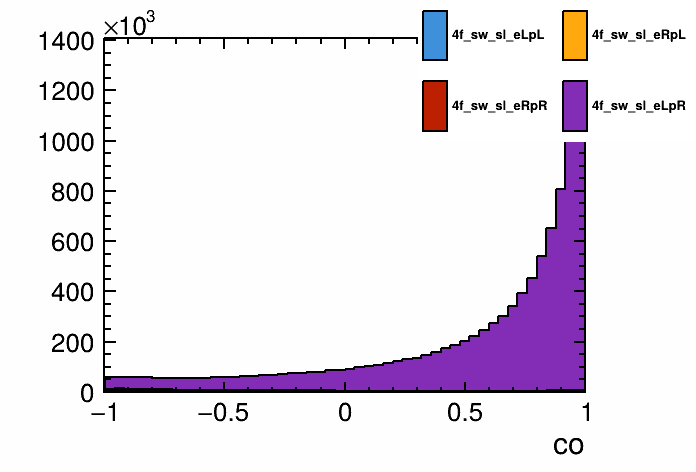

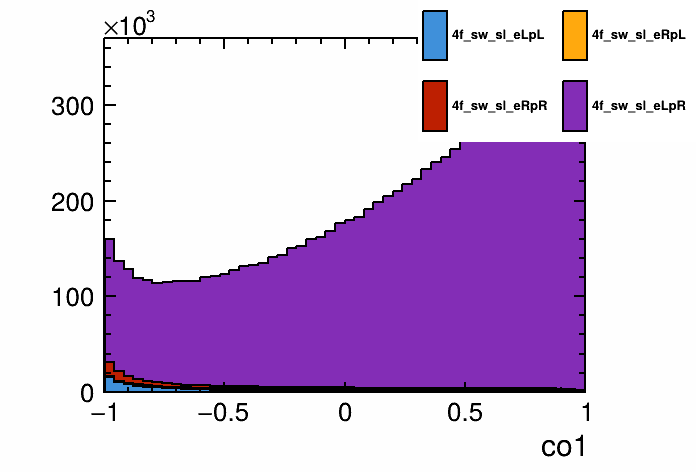

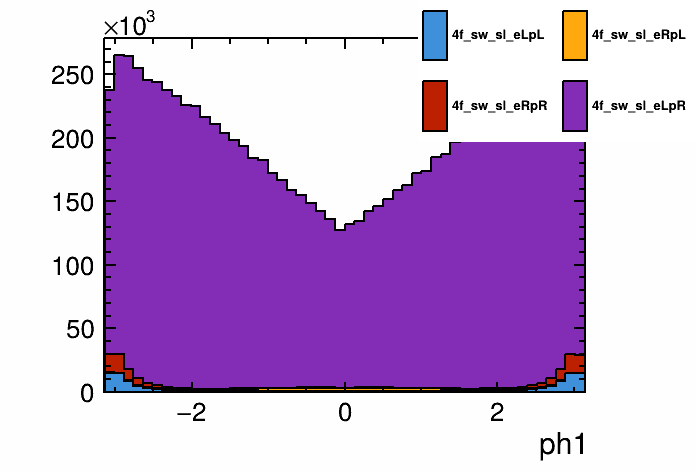

In [22]:
analysis.draw_histogram("nu_E")
analysis.draw_histogram("M_Wlep")
analysis.draw_histogram("M_Whad")
analysis.draw_histogram("co")
analysis.draw_histogram("co1")
analysis.draw_histogram("ph1")

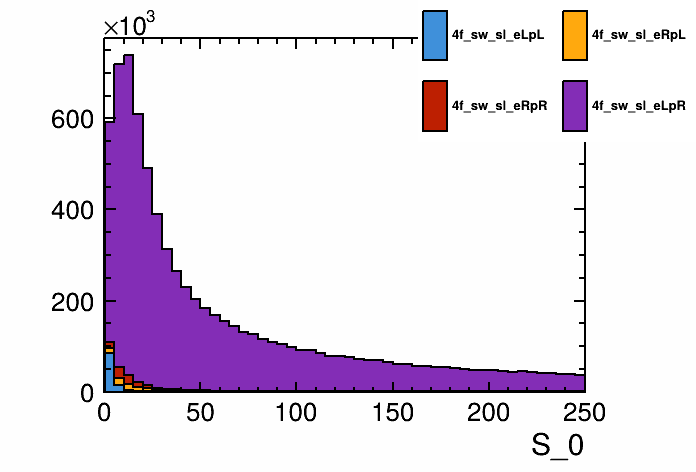

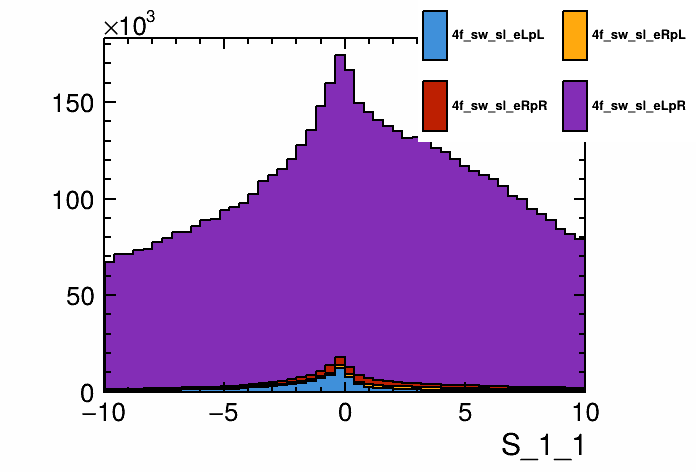

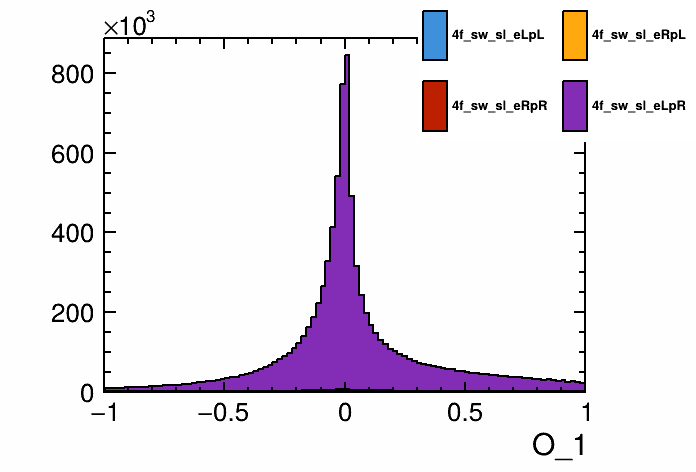

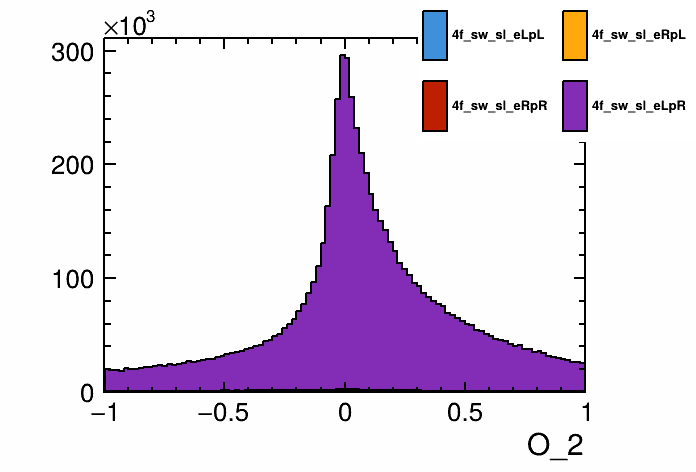

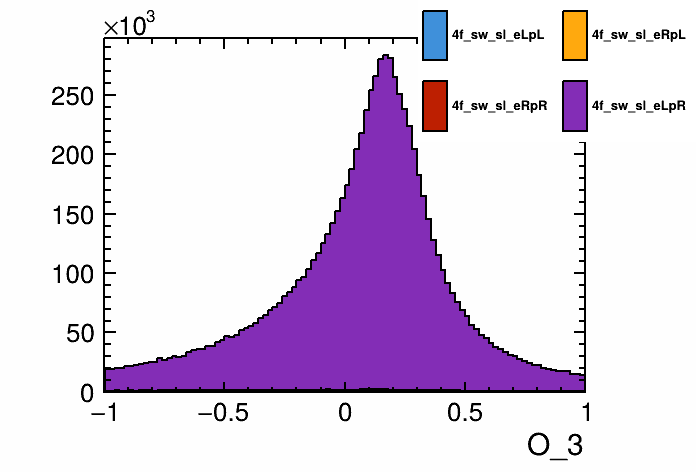

In [23]:

analysis.draw_histogram("S_0")
analysis.draw_histogram("S_1_1")
analysis.draw_histogram("O_1")
analysis.draw_histogram("O_2")
analysis.draw_histogram("O_3")

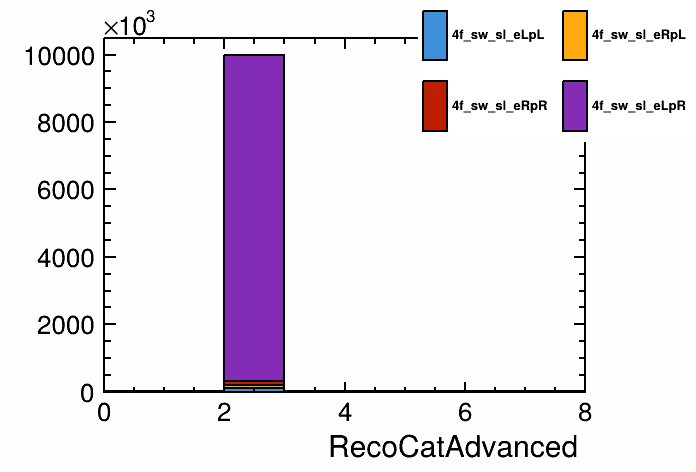

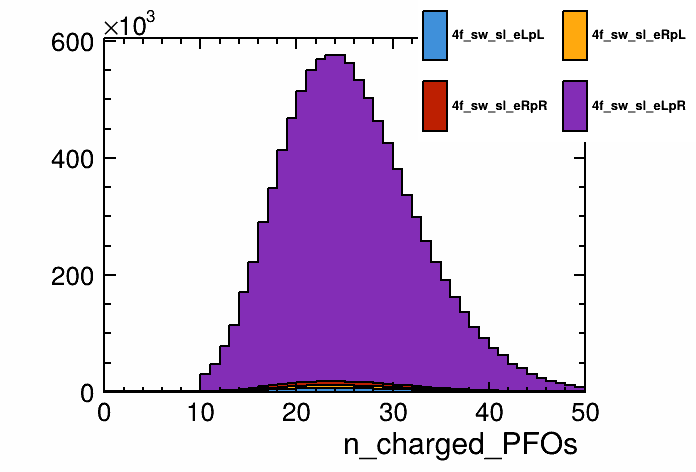

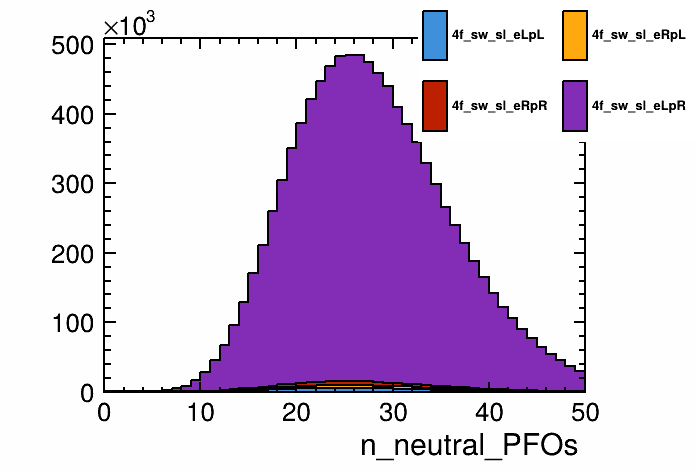

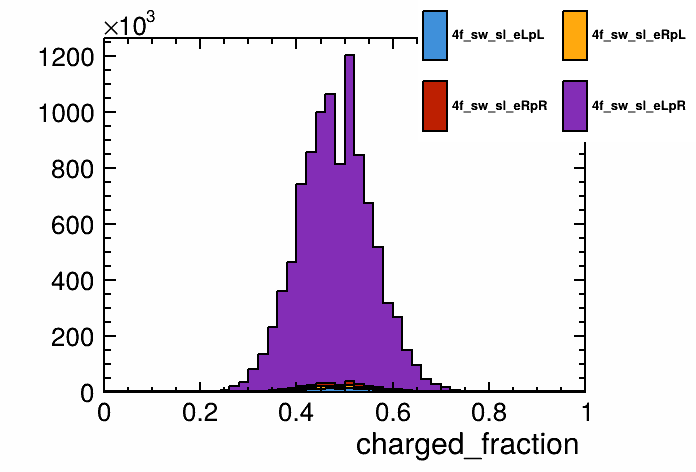

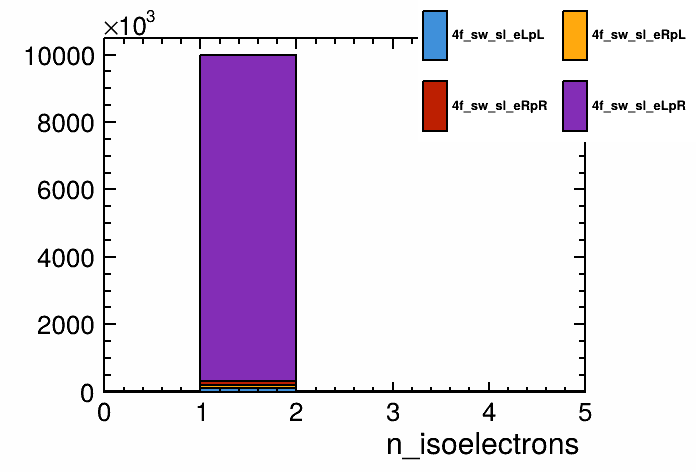

In [24]:
# unfortunately the jsroot plots break all the time, maybe it is just too much for them
# %jsroot on
# 0 - hadronic (both W decay hadronically)
# 1 - invisible semileptonic (one W decays hadronically, but the lepton is not within detector acceptance/detected)
# 2 - semileptonic electron
# 3 - semileptonic muon
# 4 - semileptonic tauon
# 5 - leptonic (both W decay leptonically)
# 6 - other, 7- broken?
analysis.draw_histogram("RecoCatAdvanced")
analysis.draw_histogram("n_charged_PFOs")
analysis.draw_histogram("n_neutral_PFOs")
analysis.draw_histogram("charged_fraction")
analysis.draw_histogram("n_isoelectrons")

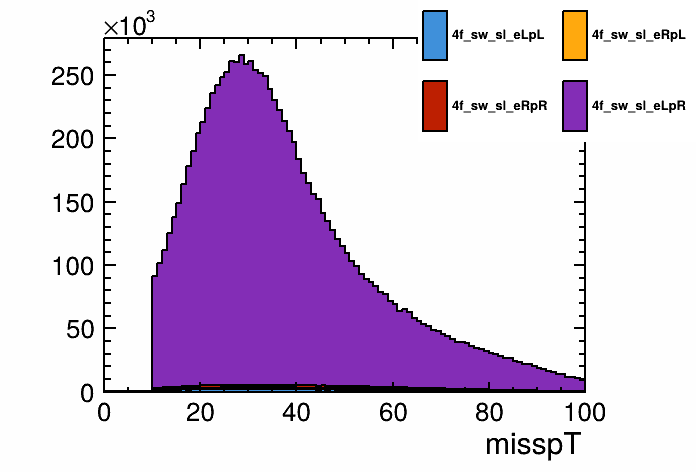

In [25]:
analysis.draw_histogram("misspT")

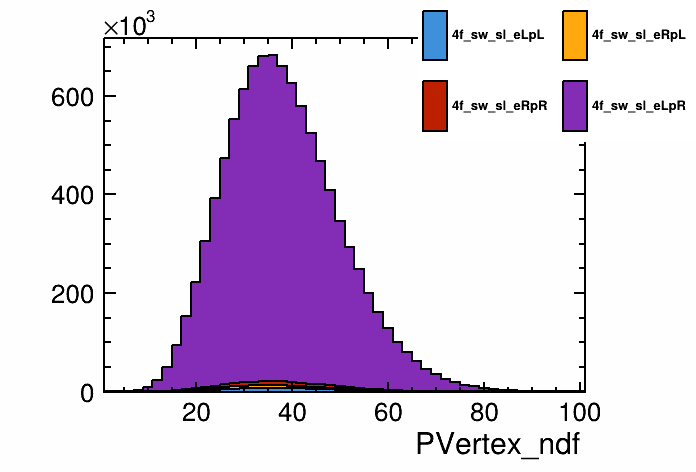

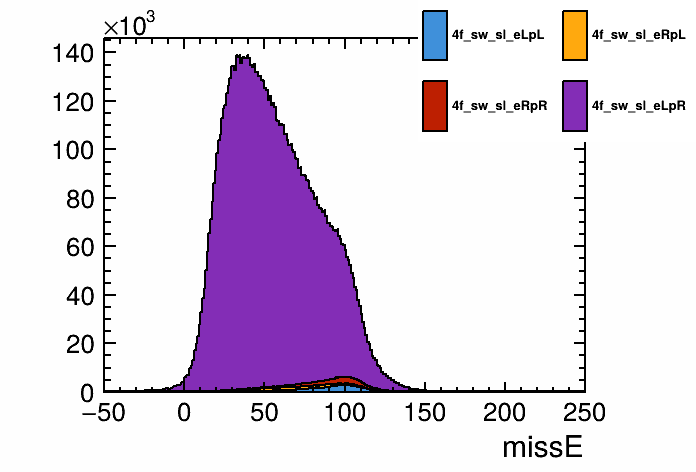

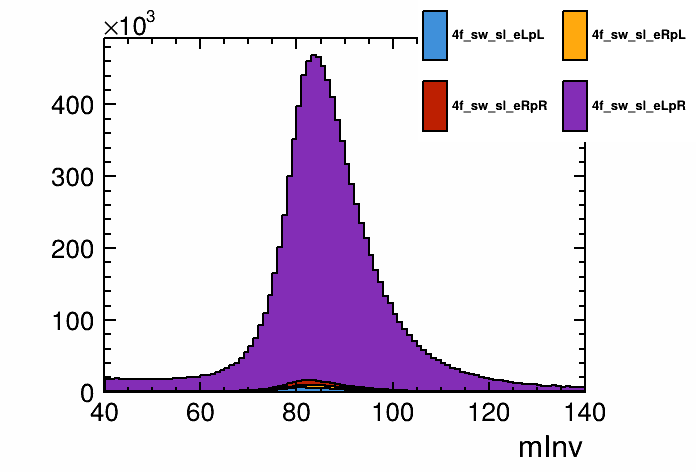

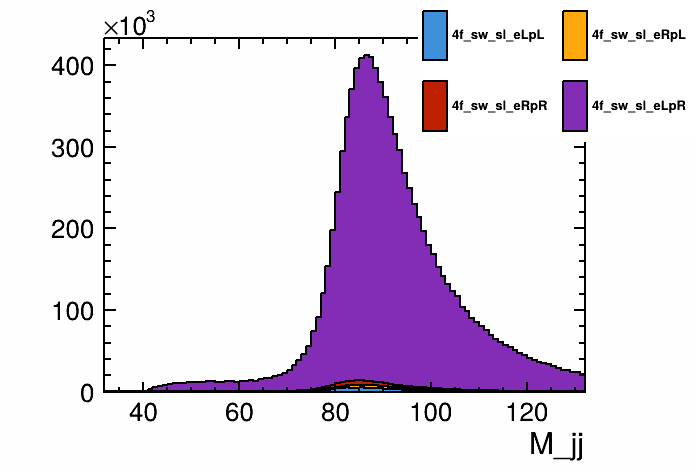

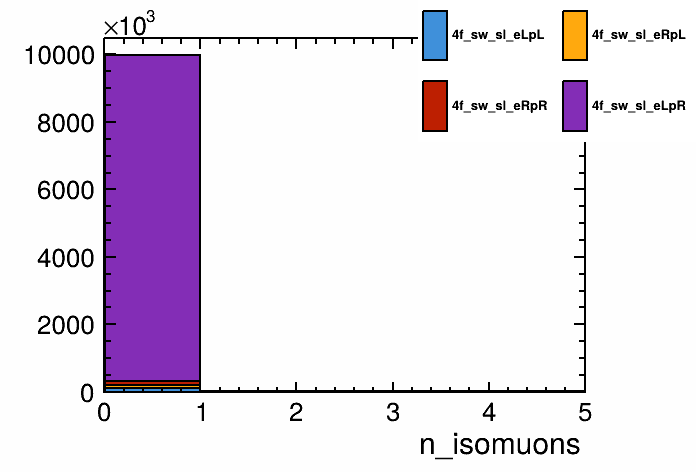

In [26]:
analysis.draw_histogram("PVertex_ndf")

analysis.draw_histogram("missE")
analysis.draw_histogram("mInv")
analysis.draw_histogram("M_jj")
analysis.draw_histogram("n_isomuons")

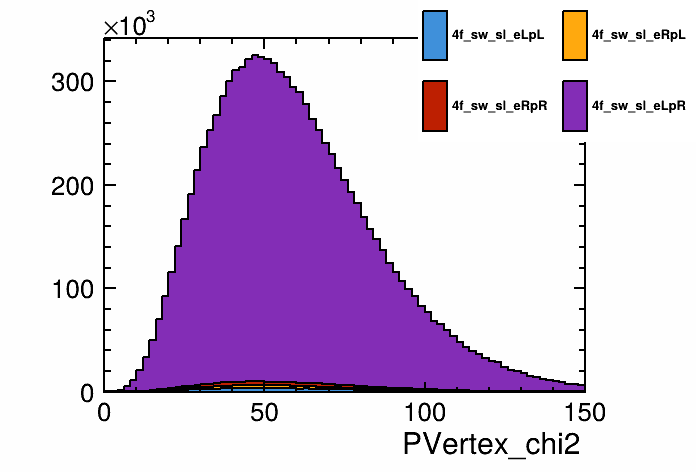

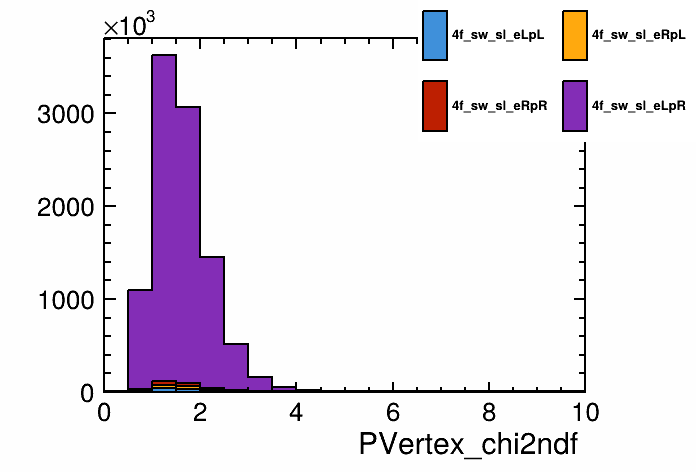

In [27]:
analysis.draw_histogram("PVertex_chi2")
analysis.draw_histogram("PVertex_chi2ndf")

In [28]:
# TODO: plot the 5 (10?) differential cross sections down here